In [1]:
%%capture
%pip install optuna

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split
from sklearn.model_selection import KFold
import torch.nn.functional as F

In [4]:
BATCHSIZE = 128
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', DEVICE)

Training device: cuda


In [5]:
%%capture
test_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=transforms.ToTensor())
full_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [50000, 10000])

train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_fc = nn.Sequential(
            nn.Linear(in_features=32*3*3, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim=2, dropout=0.5):
        super().__init__()

        self.decoder_fc = nn.Sequential(
            nn.Linear(in_features=encoded_space_dim, out_features=64),
            nn.Dropout(dropout),
            nn.ReLU(True),
            nn.Linear(in_features=64, out_features=32*3*3),
            nn.Dropout(dropout),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=0, output_padding=0, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, padding=1, output_padding=1, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, padding=1, output_padding=1, stride=2)
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [7]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    conc_out = []
    conc_label = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        conc_out.append(decoded_data.cpu())
        conc_label.append(image_batch.cpu())
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label) 
    train_loss = loss_fn(conc_out, conc_label)
    return train_loss.data

def val_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [36]:
torch.manual_seed(0)

encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=2, dropout=0)
decoder = Decoder(encoded_space_dim=2, dropout=0)

In [37]:
loss_fn = torch.nn.MSELoss()
lr = 5e-4
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

encoder.to(DEVICE)
decoder.to(DEVICE)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=288, bias=True)
    (4): Dropout(p=0, inplace=False)
    (5): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [38]:
num_epochs = 50
train_log = []
val_log = []
for epoch in range(num_epochs):
    train_loss = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    
    val_loss = val_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=DEVICE, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    
    train_log.append(train_loss.cpu().numpy())
    val_log.append(val_loss.cpu().numpy())

    print('EPOCH %d/%d: TRAIN - loss: %f || VALIDATION - loss: %f' % (epoch + 1, num_epochs, train_loss, val_loss))

# Save network parameters
torch.save(encoder.state_dict(), 'encoder0_params.pth')
torch.save(decoder.state_dict(), 'decoder0_params.pth')

EPOCH 1/50: TRAIN - loss: 0.084003 || VALIDATION - loss: 0.048349
EPOCH 2/50: TRAIN - loss: 0.041501 || VALIDATION - loss: 0.039555
EPOCH 3/50: TRAIN - loss: 0.038047 || VALIDATION - loss: 0.036988
EPOCH 4/50: TRAIN - loss: 0.035668 || VALIDATION - loss: 0.034882
EPOCH 5/50: TRAIN - loss: 0.033799 || VALIDATION - loss: 0.033363
EPOCH 6/50: TRAIN - loss: 0.032626 || VALIDATION - loss: 0.032427
EPOCH 7/50: TRAIN - loss: 0.031804 || VALIDATION - loss: 0.031637
EPOCH 8/50: TRAIN - loss: 0.031196 || VALIDATION - loss: 0.031121
EPOCH 9/50: TRAIN - loss: 0.030723 || VALIDATION - loss: 0.030873
EPOCH 10/50: TRAIN - loss: 0.030334 || VALIDATION - loss: 0.030370
EPOCH 11/50: TRAIN - loss: 0.030022 || VALIDATION - loss: 0.030134
EPOCH 12/50: TRAIN - loss: 0.029769 || VALIDATION - loss: 0.029899
EPOCH 13/50: TRAIN - loss: 0.029569 || VALIDATION - loss: 0.029591
EPOCH 14/50: TRAIN - loss: 0.029359 || VALIDATION - loss: 0.029611
EPOCH 15/50: TRAIN - loss: 0.029232 || VALIDATION - loss: 0.029304
EPOC

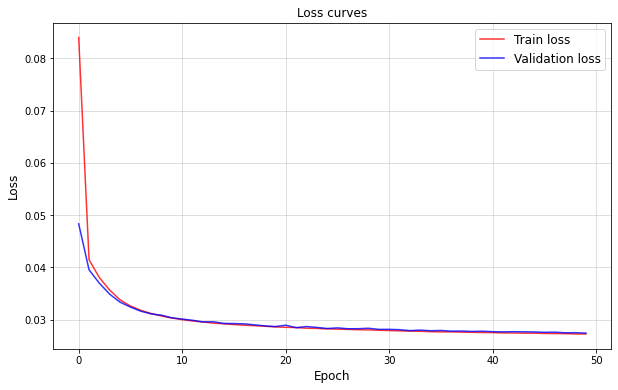

In [39]:
plt.figure(figsize=(10,6))
plt.plot(train_log, c='red', label='Train loss', alpha=0.8)
plt.plot(val_log, c='blue', label='Validation loss', alpha=0.8)
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.legend(fontsize='12')
plt.title('Loss curves', size=12)
plt.grid(alpha=0.5)
#plt.yscale('log')

In [40]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(DEVICE)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples_df = pd.DataFrame(encoded_samples)

100%|██████████| 10000/10000 [00:08<00:00, 1226.82it/s]


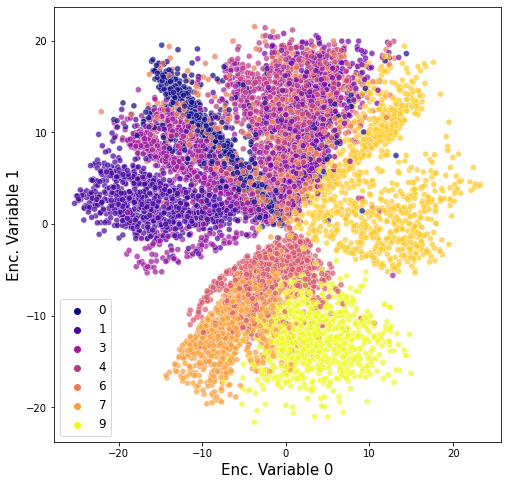

In [55]:
fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax,
                alpha=0.7,
                palette='plasma')
ax.legend(fontsize=12)
ax.set_xlabel('Enc. Variable 0', size=15)
ax.set_ylabel('Enc. Variable 1', size=15);

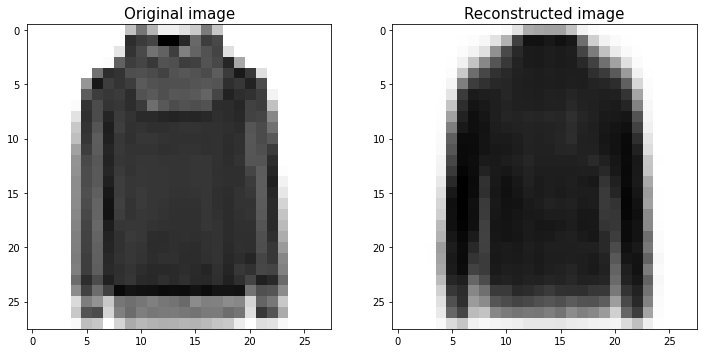

In [54]:
# Image reconstruction
idx = 5
image, label = train_dataset[idx]
encoder.eval()
decoder.eval()
with torch.no_grad():
    encoded_sample = encoder(image.unsqueeze_(0).to(DEVICE))
    decoded_sample = decoder(encoded_sample)
rec_image = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
ax[0].imshow(image.squeeze(), cmap='Greys')
ax[0].set_title('Original image', size=15)

ax[1].imshow(rec_image, cmap='Greys')
ax[1].set_title('Reconstructed image', size=15);

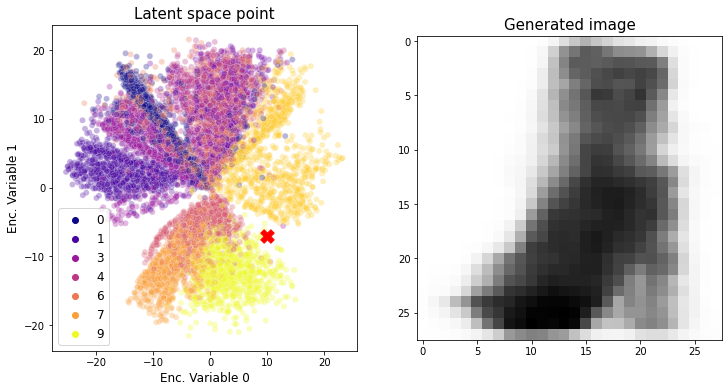

In [73]:
# Generating new images
ls_point = [10, -7]
encoded_sample = torch.Tensor(ls_point).unsqueeze_(0).to(DEVICE)
decoder.eval()
with torch.no_grad():
    decoded_sample = decoder(encoded_sample)

encoded_sample = encoded_sample.to('cpu').squeeze().numpy()
decoded_sample = decoded_sample.to('cpu').squeeze().numpy()

fig, ax = plt.subplots(figsize=(12,6), ncols=2, nrows=1)
sns.scatterplot(x='Enc. Variable 0', y='Enc. Variable 1',
                hue='label',
                data=encoded_samples_df,
                ax=ax[0],
                alpha=0.3,
                palette='plasma')
ax[0].legend(fontsize=12)
ax[0].set_xlabel('Enc. Variable 0', size=12)
ax[0].set_ylabel('Enc. Variable 1', size=12);
ax[0].scatter(*ls_point, s=180, color='red', marker='X')
ax[0].set_title('Latent space point', size=15)
ax[1].imshow(decoded_sample, cmap='Greys')
ax[1].set_title('Generated image', size=15);

AttributeError: ignored